# __Desafío - Inferencia de tópicos con EM__

## Requerimientos
- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de
distintos artistas. Cada uno de los `csv` se encuentra en la carpeta `dump`.
- Cada `csv` tiene el nombre del artista a analizar. Los archivos contienen el nombre del
artista, el género musical del artista, el nombre de la canción y las letras.
- En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico
que pueda identificar el género musical más probable dado la letra de una canción.
- Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que
hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una
matriz de documentos.

## Ejercicio 1: Preparar el ambiente de trabajo
-  Importe los módulos `numpy`, `pandas`, `matplotlib`, `seaborn`, `glob` y `os` siguiendo las
buenas prácticas. Los últimos dos módulos permitirán realizar la importación de
múltiples archivos dentro de la carpeta `dump`.
-  Para ello genere un objeto que guarde en una lista todos los archivos alojados en `dump`
utilizando `glob.glob` y `os.getcwd()` para extraer las rutas absolutas. Posteriormente
genere un objeto `pd.DataFrame` que contenga todos los `csv`.
-  Asegúrese de eliminar la columna `Unnamed: 0` que se genera por defecto.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

In [11]:
paths = glob.glob(os.getcwd() + '/dump/*.csv')
baseDf = pd.DataFrame()
for path in paths:
    artistDf = pd.read_csv(path).drop(columns=['Unnamed: 0'])
    baseDf = pd.concat([baseDf, artistDf])
baseDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9489 entries, 0 to 250
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       9489 non-null   object
 1   1       9489 non-null   object
 2   2       9489 non-null   object
 3   3       9489 non-null   object
dtypes: object(4)
memory usage: 370.7+ KB


In [14]:
baseDf.sample(5)

,0,1,2,3
70,Michael Jackson,pop,The Way You Make Me Feel,Hee! - hee! \n Ooh! \n Go on girl! \n Aaow! \n...
50,Killer Mike,hiphop,My Chrome,(Intro - Killer Mike) \n (You don't have to go...
27,Britney Spears,pop,Heart,Heart \n I know I've been hard on you \n I'm s...
74,De La Soul,hiphop,Wonce Again Long Island,(Pos Plug Wonder Why) \n (What the hell do you...
218,Kiss,rock,Right Here Right Now,I can see in your eyes \n That you're tired of...


In [16]:
baseDf['1'].value_counts()

rock      4140
hiphop    2535
metal     1582
pop       1232
Name: 1, dtype: int64

## Ejercicio 2: Matriz de ocurrencias
- Importe la clase `CountVectorizer` dentro de los módulos `feature_extraction.text`
de la librería `sklearn`.
- Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.
- Con la clase inicializada, incorpore las letras con el método `fit_transform` y guarde los
resultados en un nuevo objeto.


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words='english')
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(baseDf['3'])
# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)
# Convertimos el arreglo de frecuencias en una serie
wordSeries = pd.Series(words_freq, index=words).sort_values(ascending=False)
# Se muestran las primeras 5000 palabras
wordSeries.head(5000)

like          19629
don           17398
know          14962
got           14171
just          13978
              ...  
mayor            31
footprints       31
tweedle          31
crow             31
pearl            31
Length: 5000, dtype: int64

## Ejercicio 3: Entrenamiento del Modelo
- Importe `sklearn.decomposition.LatentDirichletAllocation` y
`sklearn.model_selection.GridSearchCV`.
- Genere una búsqueda de grilla con los siguientes hiper parámetros:
  - `n_components: [5, 10, 15]`.
  - `learning_decay: [0.7, 0.5]`.
- Entrene la búsqueda de grilla con las letras en un formato vectorizado con
`CountVectorizer`.
- Reporte brevemente cuál es la mejor combinación de hiper parámetros.

### Digresión: Latent Dirichlet Allocation
Latent Dirichlet Allocatio (LDA) es un modelo probabilístico generativo basado en Inferencia
Variacional EM. La principal utilidad de esto es la identificación de tópicos en un corpus de
texto. El proceso de inferencia se puede resumir en los siguientes pasos:
- Cada documento dentro del corpus se puede entender como una mezcla de tópicos
__comunes a nivel de corpus__.
- Esta mezcla de tópicos es latente: sólo observamos los documentos registrados y sus
palabras.
La API de `sklearn.decomposition.LatentDirichletAllocation` presenta la misma
funcionalidad de todo modelo de sklearn. Algunos puntos a considerar en la
inicialización de la clase son:
  - `n_components`: Cantidad de tópicos a inferir en un corpus.
  - `learning_method`: Forma en la que entran los datos en entrenamiento. Cuando
es 'batch', se ingresa la matriz de entrenamiento completa. Cuando es 'online', la
matriz de entrenamiento ingresa de manera secuencial en parcelas pequeñas.
  - `learning_decay`: Tasa de aprendizaje en la función de pérdida. Cuando se
implementa con `learning_method='online'`, el modelo se entrena con
Gradiente Estocástico Descendente.
  - `Perplejidad`: Busca aproximar el número óptimo de tópicos a inferir.
Técnicamente evalúa qué tan bien predice una muestra específica. En función a
un número de tópicos, define la distribución teórica de palabras representada por
los tópicos y la compara con la ocurrencia empírica de palabras en tópicos.



In [90]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [57]:
# Definimos los hiperparámetros de búsqueda
n_components = [5, 10, 15]
learning_decay = [0.7, 0.5]
# Creamos el pipeline del modelo
pipeline = Pipeline([
    ('text_vectorize', CountVectorizer(stop_words ='english')),
    ('model', GridSearchCV(LatentDirichletAllocation(random_state=19137), {'n_components': n_components, 'learning_decay': learning_decay}))
])
# Entrenamos
pipeline.fit(baseDf['3'])

Pipeline(steps=[('text_vectorize', CountVectorizer(stop_words='english')),
                ('model',
                 GridSearchCV(estimator=LatentDirichletAllocation(random_state=19137),
                              param_grid={'learning_decay': [0.7, 0.5],
                                          'n_components': [5, 10, 15]}))])

In [58]:
# Conseguimos los mejores parámetros desde el GridSearchCV
pipeline.get_params()['model'].best_params_

{'learning_decay': 0.7, 'n_components': 5}

Vemos que los mejores parámetros son `learning_decay= 0.7` y `n_components= 5`

## Ejercicio 4 : Inferencia e Identificación de Tópicos
- En base a la mejor combinación de hiper parámetros, entrene el modelo con la matriz de
atributos de las letras.
- Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15
palabras asociadas con éste. Puede implementar la siguiente línea de código para
identificar las principales palabras en un tópico:
```python
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(fit_best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))
```
- Comente a qué tópicos está asociada cada clase inferida.



In [59]:
# Creamos el contador fiteado con datos de entrenamiento
counter_train = CountVectorizer(stop_words='english')
# Creamos el modelo con la mejor combinación de parámetros
fit_best_lda = LatentDirichletAllocation(n_components=5, learning_decay=0.7, random_state=19137).fit(counter_train.fit_transform(baseDf['3']))
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(fit_best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter_train.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
like got shit don ain yo nigga fuck know cause just man em niggas bitch
tópico: 2
yeah oh know baby got like ah ya wanna just let come rock don em
tópico: 3
like na blood black body come war yeah ba dem left mi everybody right head
tópico: 4
life la god time death die world soul man dead eyes ll like just blood
tópico: 5
don love know just oh ll yeah got ve like want baby let time come


Podríamos inferir que:
- Los topicos 3 y 4 serían los mas iguales hablando de violencia, siendo 4 un poco mas 'existencial'.
- El tópico 2 sería algo mas pop o rock
- El topico 1 tiene palabras mas groseras propias del hiphop y rap
- El tópico 5 tiene palabras mas bien de nostalgia o sentimentales.

## Ejercicio 5: Identificación de probabilidades
- En base a la información generada, es posible identificar cuales van a ser los géneros
más probables de ocurrir para un artista.
- Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de
datos original. Podemos implementar esto de la siguiente manera:
```python
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_lda.transform(transformed_feats)
# esta transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3), index=df_lyrics.index )
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(docs_topics.values, axis=1) + 1
```
- Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente
brevemente cuales son las principales asociaciones existentes.
- Con esta nueva base de datos, identifique las probabilidades de pertenencia para un
artista específico.
- Grafique la distribución de las probabilidades para algún artista en específico


In [60]:
transformed_feats = counter_train.fit_transform(baseDf['3'])
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
predicted_lda = fit_best_lda.transform(transformed_feats)
# esta transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(np.round(predicted_lda, 3), index=baseDf.index )
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, fit_best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([baseDf, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(concatenated_df.loc[:,topics_for_each_doc.columns].values, axis=1) + 1

<AxesSubplot:>

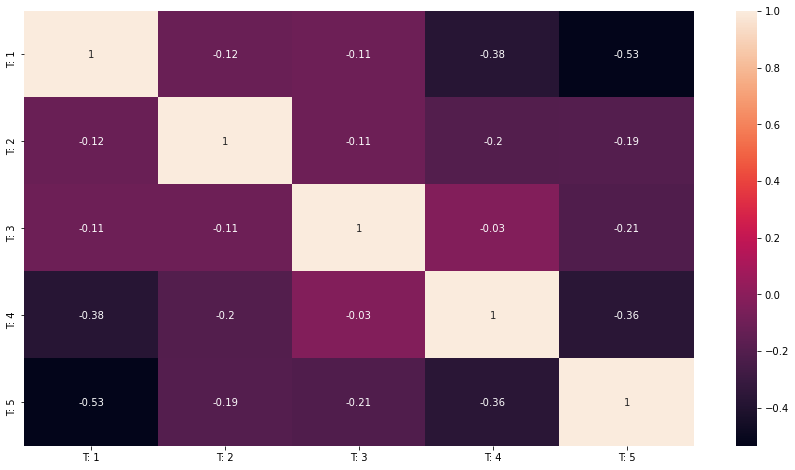

In [69]:
# Graficamos la matriz de correlaciones para los tópicos inferidos
plt.figure(figsize =(15, 8))
sns.heatmap(concatenated_df.loc[:,topics_for_each_doc.columns].corr(), annot=True)


Vemos que la correlación mas alta entre los tópicos es entre 3 y 4. Mientras que la correlación mas baja está entre los topicos 1 y 5, lo que condice nuestra sospecha de temas sentimentales y violencia.

In [76]:
# Conseguimos las predicciones medias por artista
artistsDf = concatenated_df.loc[:,['0',*topics_for_each_doc.columns]].groupby(by='0').mean()
artistsDf['highest_topic'] = np.argmax(artistsDf.loc[:,topics_for_each_doc.columns].values, axis=1) + 1
artistsDf.head(4)

,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,,,,,,
A Tribe Called Quest,0.615798,0.132553,0.041404,0.088254,0.122158,1
Anthrax,0.089094,0.047812,0.069159,0.410788,0.383112,4
Black Star,0.407870,0.206739,0.179826,0.153696,0.052000,1
Bob Dylan,0.073685,0.078624,0.025172,0.262984,0.559570,5


Vemos que para los artistas se condicen los topicos, siendo Bob Dylan mas sentimental, Anthrax como violento y A Tribe Called Quest como hiphop/rap

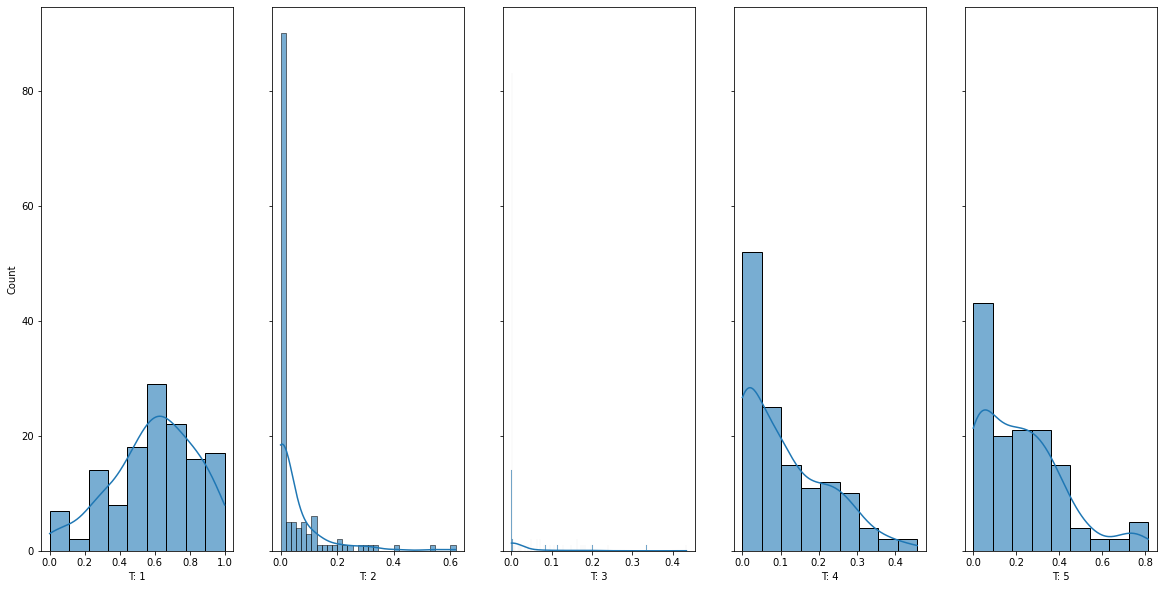

In [93]:
# Analizamos las predicciones de Kendrick Lamar
kendrickDf = concatenated_df[concatenated_df['0'] == 'Kendrick Lamar'].loc[:,topics_for_each_doc.columns]
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(20,10))
# Analizamos a Anthrax
for i, col in enumerate(kendrickDf.columns):
    sns.histplot(x=col, data=kendrickDf, ax=ax[i], kde=True, alpha=.6)

Vemos que tiene valores muy bajos para los topicos 2 y 3, luego se remonta con el topico 4 pero aún con valores menores a 0.5. Finalmente se condice el mejor topico 1 con los topicos del hiphop y rap, influenciado moderadamente por temas sentimentales y nostálgicos del topico 5.